In [ ]:
!pip install nba_api

In [ ]:
import pandas as pd
import numpy as np

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.losses import BinaryCrossentropy

In [ ]:
# Get stats for each team
from nba_api.stats.endpoints import leaguedashteamstats

raw_team_stats_21_22 = leaguedashteamstats.LeagueDashTeamStats(season_type_all_star="Regular Season", season="2021-22")
team_dataframe_21_22 = raw_team_stats_21_22.get_data_frames()[0]

gsw_21_22 = team_dataframe_21_22[team_dataframe_21_22.TEAM_ID == 1610612744]
gsw_21_22

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
9,1610612744,Golden State Warriors,82,53,29,0.646,3946.0,3323,7087,0.469,...,7,5,29,4,18,2,27,29,15,5


In [ ]:
# Helpers
def get_season_from_start(start_year: str) -> str:
  return "{}-{}".format(start_year, int(start_year[2:]) + 1)

def get_id_by_abbreviation(abbreviation: str) -> int:
  return teams.find_team_by_abbreviation(abbreviation=abbreviation)["id"]

# Given BKN @ MIL and you are BKN, should return MIL
def get_opponent(game_matchup: str, your_team: str):
  matchup_components = game_matchup.split(" ")
  left_team, right_team = matchup_components[0], matchup_components[2]
  if your_team == left_team:
    return right_team
  else:
    return left_team

def convertWLto01(wl: str) -> int:
  return 1 if wl == 'W' else 0

def get_team_stat_name(stat: str) -> str:
  return "TEAM_{}".format(stat)

def get_opponent_stat_name(stat: str) -> str:
  return "OPPONENT_{}".format(stat)

def generate_nn_labels(stats: list[str]):
  team_and_opponent_labels = []
  for stat in stats:
    team_and_opponent_labels.append("TEAM_{}".format(stat))
    team_and_opponent_labels.append("OPPONENT_{}".format(stat))
  return team_and_opponent_labels

In [ ]:
# Helper class to simplify season handling
class Season:
  def __init__(self, start_year: str):
    self.start_year = start_year
  def formatted_season(self):
    # "2021" -> "2021-"
    return get_season_from_start(self.start_year)


In [ ]:
# Convenience objects
season_2021 = Season("2021")
season_2022 = Season("2022")
season_2023 = Season("2023")

In [ ]:
from nba_api.stats.endpoints import cumestatsteamgames

def fetch_all_team_stats(start_year: Season):
  # Requires format 2025-26 season for 2025-2026 season
  all_teams_raw = leaguedashteamstats.LeagueDashTeamStats(season_type_all_star="Regular Season", season=start_year.formatted_season())

  return all_teams_raw.get_data_frames()[0]


In [ ]:
team_stats_2021 = fetch_all_team_stats(season_2021)
team_stats_2022 = fetch_all_team_stats(season_2022)
team_stats_2023 = fetch_all_team_stats(season_2023)

In [ ]:
team_stats_2023

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,82,36,46,0.439,3971.0,3529,7584,0.465,...,6,16,16,16,26,22,15,7,5,21
1,1610612738,Boston Celtics,82,64,18,0.780,3966.0,3601,7396,0.487,...,2,14,1,27,1,1,2,30,2,1
2,1610612751,Brooklyn Nets,82,32,50,0.390,3961.0,3334,7307,0.456,...,11,20,12,28,12,16,13,21,25,22
3,1610612766,Charlotte Hornets,82,21,61,0.256,3946.0,3281,7133,0.460,...,30,26,18,25,25,13,7,29,28,30
4,1610612741,Chicago Bulls,82,39,43,0.476,3996.0,3448,7339,0.470,...,14,23,3,9,18,14,17,14,22,20
5,1610612739,Cleveland Cavaliers,82,48,34,0.585,3961.0,3425,7147,0.479,...,17,8,17,19,21,17,5,16,20,13
6,1610612742,Dallas Mavericks,82,50,32,0.610,3941.0,3535,7352,0.481,...,21,19,4,24,17,2,10,2,7,14
7,1610612743,Denver Nuggets,82,57,25,0.695,3941.0,3610,7279,0.496,...,7,3,5,21,10,12,9,26,14,4
8,1610612765,Detroit Pistons,82,14,68,0.171,3951.0,3353,7236,0.463,...,16,22,28,30,20,25,28,28,27,28
9,1610612744,Golden State Warriors,82,46,36,0.561,3966.0,3582,7515,0.477,...,1,4,23,23,23,15,22,24,8,12


In [ ]:
# Returns a table of game, with a team and opponent + corresponding win percentages
# This WILL duplicate games
def prepare_dataset(season_start_year: Season, team_stats, additional_columns: list[str]=[]):
  season_data = leaguegamefinder.LeagueGameFinder(season_nullable=season_start_year.formatted_season(), league_id_nullable="00", season_type_nullable="Regular Season")
  season_data_df = season_data.get_data_frames()[0]

  # Starting fresh with a new copy
  individual_games = pd.DataFrame()

  # Copy over basic columns
  individual_games["TEAM_NAME"] = season_data_df["TEAM_NAME"]
  individual_games["TEAM_ABBREVIATION"] = season_data_df["TEAM_ABBREVIATION"]
  individual_games["TEAM_ID"] = season_data_df["TEAM_ABBREVIATION"].map(get_id_by_abbreviation)
  individual_games["GAME_ID"] = season_data_df["GAME_ID"]

  # Extract opponent abbr. using pandas apply
  individual_games["OPPONENT_ABBREVIATION"] = season_data_df.apply(lambda x: get_opponent(game_matchup=x["MATCHUP"], your_team=x["TEAM_ABBREVIATION"]), axis=1)
  individual_games["OPPONENT_ID"] = individual_games["OPPONENT_ABBREVIATION"].map(get_id_by_abbreviation)
  individual_games["WL"] = season_data_df["WL"]

  for stat_name in additional_columns:
    # Remove team_name column to prevent name clash when merging
    id_to_win = team_stats[["TEAM_ID", stat_name]]

    # Map the team id to what their win percentage is
    individual_games = pd.merge(individual_games, id_to_win, how="left", on="TEAM_ID")
    individual_games.rename(columns={stat_name : get_team_stat_name(stat_name)}, inplace=True)

    # Requires left_on because the same columns have different names
    individual_games = pd.merge(individual_games, id_to_win, how="left", left_on="OPPONENT_ID", right_on="TEAM_ID")
    individual_games.rename(columns={stat_name : get_opponent_stat_name(stat_name)}, inplace=True)

    # Remove the leftover columns from merging on columns with different names\
    # We end up with TEAM_ID_x and TEAM_ID_y
    # We drop y and rename x to just TEAM_ID
    individual_games = individual_games.drop(["TEAM_ID_y"], axis=1)
    individual_games.rename(columns={"TEAM_ID_x" : "TEAM_ID"}, inplace=True)
  individual_games["WIN"] = individual_games["WL"].map(convertWLto01)

  return individual_games

def prepare_win_pct_data(season: Season, team_stats):
  return prepare_dataset(season, team_stats, additional_columns=["W_PCT"])

# Using Naive Win Percentage Only

In [ ]:
# Beware, this function will duplicate games (Which is intended in this case but may not always be true)
games_2021 = prepare_win_pct_data(season_2021, team_stats_2021)
tmp = games_2021[games_2021.GAME_ID == "0022101222"]
tmp

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
2,LA Clippers,LAC,1610612746,0022101222,OKC,1610612760,W,0.512,0.293,1
8,Oklahoma City Thunder,OKC,1610612760,0022101222,LAC,1610612746,L,0.293,0.512,0


In [ ]:
games_2022 = prepare_win_pct_data(season_2022, team_stats_2022)
games_2022

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Dallas Mavericks,DAL,1610612742,0022201224,SAS,1610612759,L,0.463,0.268,0
1,San Antonio Spurs,SAS,1610612759,0022201224,DAL,1610612742,W,0.268,0.463,1
2,Phoenix Suns,PHX,1610612756,0022201229,LAC,1610612746,L,0.549,0.537,0
3,Sacramento Kings,SAC,1610612758,0022201227,DEN,1610612743,L,0.585,0.646,0
4,Washington Wizards,WAS,1610612764,0022201222,HOU,1610612745,L,0.427,0.268,0
...,...,...,...,...,...,...,...,...,...,...
2455,Brooklyn Nets,BKN,1610612751,0022200006,NOP,1610612740,L,0.549,0.512,0
2456,Los Angeles Lakers,LAL,1610612747,0022200002,GSW,1610612744,L,0.524,0.537,0
2457,Philadelphia 76ers,PHI,1610612755,0022200001,BOS,1610612738,L,0.659,0.695,0
2458,Golden State Warriors,GSW,1610612744,0022200002,LAL,1610612747,W,0.537,0.524,1


In [ ]:
games_2023 = prepare_win_pct_data(season_2023, team_stats_2023)
games_2023

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Los Angeles Lakers,LAL,1610612747,0022301195,NOP,1610612740,W,0.573,0.598,1
1,New Orleans Pelicans,NOP,1610612740,0022301195,LAL,1610612747,L,0.598,0.573,0
2,LA Clippers,LAC,1610612746,0022301199,HOU,1610612745,L,0.622,0.500,0
3,Indiana Pacers,IND,1610612754,0022301188,ATL,1610612737,W,0.573,0.439,1
4,Golden State Warriors,GSW,1610612744,0022301198,UTA,1610612762,W,0.561,0.378,1
...,...,...,...,...,...,...,...,...,...,...
2455,Oklahoma City Thunder,OKC,1610612760,0022300070,CHI,1610612741,W,0.695,0.476,1
2456,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0
2457,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0.573,0.695,0


In [ ]:
# Combine all three recent seasons together
recent_three_seasons = pd.concat([games_2021, games_2022, games_2023])
recent_three_seasons.sample(frac=1) # Shuffle data
recent_three_seasons

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN
0,Atlanta Hawks,ATL,1610612737,0022101221,HOU,1610612745,W,0.524,0.244,1
1,San Antonio Spurs,SAS,1610612759,0022101219,DAL,1610612742,L,0.415,0.634,0
2,LA Clippers,LAC,1610612746,0022101222,OKC,1610612760,W,0.512,0.293,1
3,Cleveland Cavaliers,CLE,1610612739,0022101218,MIL,1610612749,W,0.537,0.622,1
4,Utah Jazz,UTA,1610612762,0022101230,POR,1610612757,W,0.598,0.329,1
...,...,...,...,...,...,...,...,...,...,...
2455,Oklahoma City Thunder,OKC,1610612760,0022300070,CHI,1610612741,W,0.695,0.476,1
2456,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0
2457,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0.573,0.695,0


In [ ]:
# We must convert to numpy as input to the neural network
# In the future the same approach can be used with any desired columns
raw_win_pct = recent_three_seasons[["TEAM_W_PCT", "OPPONENT_W_PCT"]].to_numpy()
raw_win_pct

array([[0.524, 0.244],
       [0.415, 0.634],
       [0.512, 0.293],
       ...,
       [0.598, 0.561],
       [0.573, 0.695],
       [0.695, 0.573]])

In [ ]:
raw_labels = recent_three_seasons[["WIN"]].to_numpy()
raw_labels

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
training_size = 5000

basic_train_input = raw_win_pct[:training_size]
basic_train_label = raw_labels[:training_size]

basic_test_input = raw_win_pct[training_size:]
basic_test_label = raw_labels[training_size:]

In [ ]:
model = Sequential()
model.add(keras.Input(shape=(2,)))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

In [ ]:
# fit the model to the training data
history = model.fit(basic_train_input, basic_train_label, epochs=20, validation_data = (basic_test_input, basic_test_label))

result = model.evaluate(x=basic_test_input, y=basic_test_label)
dict(zip(model.metrics_names, result))

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5128 - loss: 0.7009 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5151 - val_loss: 0.6891
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5369 - loss: 0.6892 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6370 - val_loss: 0.6832
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6090 - loss: 0.6847 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6479 - val_loss: 0.6797
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6100 - loss: 0.6836 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6550 - val_loss: 0.6768
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6353 - loss: 0.6819 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6567 - val_loss: 0.6743
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━

{'loss': 0.6385620832443237, 'compile_metrics': 0.6777310967445374}

In [ ]:
binary_results = model.predict(x=basic_test_input) > 0.5

correct_predictions = 0
total_predictions = 0
for result_pair in zip(binary_results, basic_test_label):
  total_predictions += 1
  if (result_pair[0][0] == result_pair[1][0]):
    correct_predictions += 1

print("correct: {}, total: {}, accuracy pct: {}".format(correct_predictions, total_predictions, correct_predictions / total_predictions))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
correct: 1613, total: 2380, accuracy pct: 0.6777310924369748


# Adding Additional General Team Statistics

In [ ]:
addl_stats = ["W_PCT", "FGA", "REB_RANK", "FG_PCT", "FG3_PCT", "FT_PCT", "OREB", "DREB", "AST", "TOV", "STL", "PFD", "PLUS_MINUS"]
more_2023 = prepare_dataset(season_2023, team_stats_2023, additional_columns=addl_stats)
more_2023

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,TEAM_FGA,...,OPPONENT_AST,TEAM_TOV,OPPONENT_TOV,TEAM_STL,OPPONENT_STL,TEAM_PFD,OPPONENT_PFD,TEAM_PLUS_MINUS,OPPONENT_PLUS_MINUS,WIN
0,Los Angeles Lakers,LAL,1610612747,0022301195,NOP,1610612740,W,0.573,0.598,7177,...,2210,1146.0,1067.0,605,684,1619,1507,49.0,362.0,1
1,New Orleans Pelicans,NOP,1610612740,0022301195,LAL,1610612747,L,0.598,0.573,7165,...,2340,1067.0,1146.0,684,605,1507,1619,362.0,49.0,0
2,LA Clippers,LAC,1610612746,0022301199,HOU,1610612745,L,0.622,0.500,7108,...,2035,1078.0,1045.0,640,639,1537,1609,269.0,92.0,0
3,Indiana Pacers,IND,1610612754,0022301188,ATL,1610612737,W,0.573,0.439,7599,...,2180,1059.0,1110.0,631,615,1501,1594,250.0,-179.0,1
4,Golden State Warriors,GSW,1610612744,0022301198,UTA,1610612762,W,0.561,0.378,7515,...,2232,1174.0,1285.0,572,537,1471,1577,214.0,-401.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Oklahoma City Thunder,OKC,1610612760,0022300070,CHI,1610612741,W,0.695,0.476,7324,...,2048,1039.0,1004.0,694,638,1548,1538,608.0,-118.0,1
2456,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,7515,...,2218,1174.0,1221.0,572,610,1471,1612,214.0,251.0,0
2457,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,7063,...,2402,1221.0,1174.0,610,572,1612,1471,251.0,214.0,1
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0.573,0.695,7177,...,2415,1146.0,1036.0,605,585,1619,1467,49.0,431.0,0


In [ ]:
# Generate data for the other seasons
more_2021 = prepare_dataset(season_2021, team_stats_2021, additional_columns=addl_stats)
more_2022 = prepare_dataset(season_2022, team_stats_2022, additional_columns=addl_stats)

In [ ]:
additional_stats_merged = pd.concat([more_2021, more_2022, more_2023])
raw_additional_stats = additional_stats_merged[generate_nn_labels(addl_stats)].to_numpy()
raw_additional_stats

array([[ 5.240e-01,  2.440e-01,  7.241e+03, ...,  1.812e+03,  1.280e+02,
        -6.950e+02],
       [ 4.150e-01,  6.340e-01,  7.601e+03, ...,  1.645e+03,  1.000e+01,
         2.710e+02],
       [ 5.120e-01,  2.930e-01,  7.170e+03, ...,  1.462e+03,  2.000e+00,
        -6.640e+02],
       ...,
       [ 5.980e-01,  5.610e-01,  7.063e+03, ...,  1.471e+03,  2.510e+02,
         2.140e+02],
       [ 5.730e-01,  6.950e-01,  7.177e+03, ...,  1.467e+03,  4.900e+01,
         4.310e+02],
       [ 6.950e-01,  5.730e-01,  7.279e+03, ...,  1.619e+03,  4.310e+02,
         4.900e+01]])

In [ ]:
raw_additional_stats_labels = additional_stats_merged[["WIN"]].to_numpy()
raw_additional_stats_labels

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
addl_stats_training_size = 5000
addl_stats_train_input = raw_additional_stats[:addl_stats_training_size]
addl_stats_train_label = raw_additional_stats_labels[:addl_stats_training_size]

addl_stats_test_input = raw_additional_stats[addl_stats_training_size:]
addl_stats_test_label = raw_additional_stats_labels[addl_stats_training_size:]

from keras.regularizers import l2

lmbda = 0.01

model = Sequential()
model.add(keras.Input(shape=(26,)))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

In [ ]:
# fit the model to the training data
history = model.fit(addl_stats_train_input, addl_stats_train_label, epochs=80, validation_data = (addl_stats_test_input, addl_stats_test_label))

result = model.evaluate(x=addl_stats_test_input, y=addl_stats_test_label)
dict(zip(model.metrics_names, result))

Epoch 1/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0379 - binary_accuracy: 0.4948 - loss: 642.9016 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 65.0513
Epoch 2/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4929 - loss: 64.0550 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 61.1335
Epoch 3/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4956 - loss: 60.1978 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 57.4542
Epoch 4/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5129 - loss: 56.5755 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 53.9989
Epoch 5/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.4877 - loss: 53.1737 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5000 - val_loss: 50.7539
Epoch 6/80
157/157 ━━━━━━━━━━━━━━

{'loss': 1.1437231302261353, 'compile_metrics': 0.5}

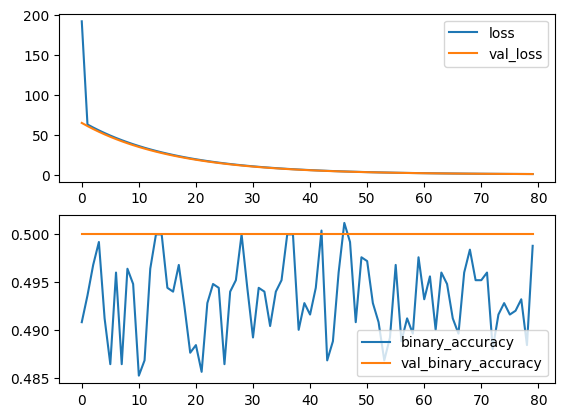

In [ ]:
import matplotlib.pyplot as plt

def plot_model_results(history):
  fig, axs = plt.subplots(2)
  axs[0].plot(history['loss'], label='loss')
  axs[0].plot(history['val_loss'], label='val_loss')
  axs[0].legend()

  axs[1].plot(history['binary_accuracy'], label="binary_accuracy")
  axs[1].plot(history['val_binary_accuracy'], label="val_binary_accuracy")
  axs[1].legend()

plot_model_results(history.history)

## Conclusions

After lots of tweaking around with the variety of columns and training epochs/layers, we couldn't push above 67% accuracy purely using general team stats.

# Adding More Game Specific Stats

Goal: Determine if conditions per game affect outcome

- Days rest prior to game

- Number of injuries (?)

In [ ]:
game_specific = prepare_dataset(season_2023, team_stats_2023)
game_specific

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,WIN
0,Los Angeles Lakers,LAL,1610612747,0022301195,NOP,1610612740,W,1
1,New Orleans Pelicans,NOP,1610612740,0022301195,LAL,1610612747,L,0
2,LA Clippers,LAC,1610612746,0022301199,HOU,1610612745,L,0
3,Indiana Pacers,IND,1610612754,0022301188,ATL,1610612737,W,1
4,Golden State Warriors,GSW,1610612744,0022301198,UTA,1610612762,W,1
...,...,...,...,...,...,...,...,...
2455,Oklahoma City Thunder,OKC,1610612760,0022300070,CHI,1610612741,W,1
2456,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0
2457,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,1
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0


## Rest Days

We get rest days between games by assigning game IDs to their game date (The API did not originally give these pieces of data together)

If a team is playing their first game, we set rest games to 0.

In [ ]:
from nba_api.stats.endpoints import leaguegamelog


log_2023 = leaguegamelog.LeagueGameLog(season=season_2023.formatted_season(), season_type_all_star="Regular Season")

log_2023 = log_2023.get_data_frames()[0]
log_2023

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,240,41,...,31,44,23,5,4,12,18,107,-12,1
1,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,48,...,33,42,29,9,6,12,15,119,12,1
2,22023,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,240,36,...,31,49,19,11,6,11,23,104,-4,1
3,22023,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,240,42,...,43,60,23,5,7,19,22,108,4,1
4,22023,1610612746,LAC,LA Clippers,0022300074,2023-10-25,LAC vs. POR,W,240,47,...,31,45,36,11,7,18,20,123,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,22023,1610612746,LAC,LA Clippers,0022301199,2024-04-14,LAC vs. HOU,L,240,41,...,35,51,23,13,8,12,14,105,-11,1
2456,22023,1610612763,MEM,Memphis Grizzlies,0022301193,2024-04-14,MEM vs. DEN,L,240,45,...,27,43,22,9,2,13,18,111,-15,1
2457,22023,1610612744,GSW,Golden State Warriors,0022301198,2024-04-14,GSW vs. UTA,W,240,45,...,30,42,35,10,6,9,14,123,7,1
2458,22023,1610612762,UTA,Utah Jazz,0022301198,2024-04-14,UTA @ GSW,L,240,46,...,34,48,22,6,5,20,20,116,-7,1


In [ ]:
cleaned = log_2023[["GAME_ID", "GAME_DATE"]]
cleaned = cleaned.drop_duplicates()
cleaned

,GAME_ID,GAME_DATE
0,0022300061,2023-10-24
2,0022300062,2023-10-24
4,0022300074,2023-10-25
5,0022300072,2023-10-25
6,0022300071,2023-10-25
...,...,...
2444,0022301189,2024-04-14
2446,0022301194,2024-04-14
2447,0022301199,2024-04-14
2449,0022301193,2024-04-14


In [ ]:
rd_with_dates = pd.merge(game_specific, cleaned, how="left", on="GAME_ID")
rd_with_dates["LAST_GAME_DATE"] = rd_with_dates.sort_values(by="GAME_DATE").groupby(["TEAM_ID"])["GAME_DATE"].shift(1)
rd_with_dates["LAST_GAME_DATE"] = rd_with_dates["LAST_GAME_DATE"].fillna(rd_with_dates["GAME_DATE"])
rd_with_dates["GAME_DATE"] = pd.to_datetime(rd_with_dates["GAME_DATE"])
rd_with_dates["LAST_GAME_DATE"] = pd.to_datetime(rd_with_dates["LAST_GAME_DATE"])
rd_with_dates["NUM_REST_DAYS"] = (rd_with_dates["GAME_DATE"] - rd_with_dates["LAST_GAME_DATE"]).dt.days
rd_with_dates

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
0,Los Angeles Lakers,LAL,1610612747,0022301195,NOP,1610612740,W,1,2024-04-14,2024-04-12,2
1,New Orleans Pelicans,NOP,1610612740,0022301195,LAL,1610612747,L,0,2024-04-14,2024-04-12,2
2,LA Clippers,LAC,1610612746,0022301199,HOU,1610612745,L,0,2024-04-14,2024-04-12,2
3,Indiana Pacers,IND,1610612754,0022301188,ATL,1610612737,W,1,2024-04-14,2024-04-12,2
4,Golden State Warriors,GSW,1610612744,0022301198,UTA,1610612762,W,1,2024-04-14,2024-04-12,2
...,...,...,...,...,...,...,...,...,...,...,...
2455,Oklahoma City Thunder,OKC,1610612760,0022300070,CHI,1610612741,W,1,2023-10-25,2023-10-25,0
2456,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0,2023-10-24,2023-10-24,0
2457,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,1,2023-10-24,2023-10-24,0
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0,2023-10-24,2023-10-24,0


## Generalized approach

We can now generalize this approach into a function for each season

In [ ]:
# We assume the input is one of the basic DataFrame formats
# we created earlier in this notebook with each row
# corresponding to one team's view of a match
def add_days_rest_column(season: Season, basic_game_data: pd.DataFrame):
  log = leaguegamelog.LeagueGameLog(season=season.formatted_season(), season_type_all_star="Regular Season")
  log = log.get_data_frames()[0]

  deduplicated = log[["GAME_ID", "GAME_DATE"]]
  deduplicated = deduplicated.drop_duplicates()

  with_dates = pd.merge(basic_game_data, deduplicated, how="left", on="GAME_ID")
  with_dates["LAST_GAME_DATE"] = with_dates.sort_values(by="GAME_DATE").groupby(["TEAM_ID"])["GAME_DATE"].shift(1)
  with_dates["LAST_GAME_DATE"] = with_dates["LAST_GAME_DATE"].fillna(with_dates["GAME_DATE"])
  with_dates["GAME_DATE"] = pd.to_datetime(with_dates["GAME_DATE"])
  with_dates["LAST_GAME_DATE"] = pd.to_datetime(with_dates["LAST_GAME_DATE"])
  with_dates["NUM_REST_DAYS"] = (with_dates["GAME_DATE"] - with_dates["LAST_GAME_DATE"]).dt.days
  return with_dates

add_days_rest_column(season_2023, games_2023)

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
0,Los Angeles Lakers,LAL,1610612747,0022301195,NOP,1610612740,W,0.573,0.598,1,2024-04-14,2024-04-12,2
1,New Orleans Pelicans,NOP,1610612740,0022301195,LAL,1610612747,L,0.598,0.573,0,2024-04-14,2024-04-12,2
2,LA Clippers,LAC,1610612746,0022301199,HOU,1610612745,L,0.622,0.500,0,2024-04-14,2024-04-12,2
3,Indiana Pacers,IND,1610612754,0022301188,ATL,1610612737,W,0.573,0.439,1,2024-04-14,2024-04-12,2
4,Golden State Warriors,GSW,1610612744,0022301198,UTA,1610612762,W,0.561,0.378,1,2024-04-14,2024-04-12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Oklahoma City Thunder,OKC,1610612760,0022300070,CHI,1610612741,W,0.695,0.476,1,2023-10-25,2023-10-25,0
2456,Golden State Warriors,GSW,1610612744,0022300062,PHX,1610612756,L,0.561,0.598,0,2023-10-24,2023-10-24,0
2457,Phoenix Suns,PHX,1610612756,0022300062,GSW,1610612744,W,0.598,0.561,1,2023-10-24,2023-10-24,0
2458,Los Angeles Lakers,LAL,1610612747,0022300061,DEN,1610612743,L,0.573,0.695,0,2023-10-24,2023-10-24,0


## Neural Network + Rest Days

We apply rest days to our neural network

In [ ]:
rest_days_2021 = add_days_rest_column(season_2021, games_2021)
rest_days_2022 = add_days_rest_column(season_2022, games_2022)
rest_days_2023 = add_days_rest_column(season_2023, games_2023)

rest_days_merged = pd.concat([rest_days_2021, rest_days_2022, rest_days_2023])
rest_days_merged = rest_days_merged.sample(frac=1) # Shuffle the data
rest_days_merged

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
2080,Sacramento Kings,SAC,1610612758,0022300212,DAL,1610612742,W,0.561,0.610,1,2023-11-19,2023-11-17,2
1020,Orlando Magic,ORL,1610612753,0022300694,MIN,1610612750,W,0.573,0.683,1,2024-02-02,2024-01-31,2
158,Denver Nuggets,DEN,1610612743,0022101159,MIN,1610612750,L,0.585,0.561,0,2022-04-01,2022-03-30,2
907,Detroit Pistons,DET,1610612765,0022100782,MIN,1610612750,L,0.280,0.561,0,2022-02-03,2022-02-01,2
848,Miami Heat,MIA,1610612748,0022100811,WAS,1610612764,W,0.646,0.427,1,2022-02-07,2022-02-05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,Los Angeles Lakers,LAL,1610612747,0022100781,POR,1610612757,W,0.402,0.329,1,2022-02-02,2022-01-30,3
1693,Minnesota Timberwolves,MIN,1610612750,0022100387,CLE,1610612739,L,0.561,0.537,0,2021-12-10,2021-12-08,2
1879,Brooklyn Nets,BKN,1610612751,0022200290,POR,1610612757,W,0.549,0.402,1,2022-11-27,2022-11-25,2
1830,Orlando Magic,ORL,1610612753,0022301217,DET,1610612765,W,0.573,0.171,1,2023-12-08,2023-12-06,2


In [ ]:
rd_stat_labels = generate_nn_labels(["W_PCT"])
rd_stat_labels.append("NUM_REST_DAYS")
raw_rd_input = rest_days_merged[rd_stat_labels].to_numpy()
raw_rd_input

array([[0.561, 0.61 , 2.   ],
       [0.573, 0.683, 2.   ],
       [0.585, 0.561, 2.   ],
       ...,
       [0.549, 0.402, 2.   ],
       [0.573, 0.171, 2.   ],
       [0.537, 0.451, 3.   ]])

In [ ]:
raw_rd_outputs = rest_days_merged["WIN"].to_numpy()
raw_rd_outputs

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
training_size = 5000

rd_train_input = raw_rd_input[:training_size]
rd_train_label = raw_rd_outputs[:training_size]

rd_test_input = raw_rd_input[training_size:]
rd_test_label = raw_rd_outputs[training_size:]

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5571 - loss: 0.7102 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6038 - val_loss: 0.7059
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.6132 - loss: 0.7060 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5235 - val_loss: 0.7058
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5826 - loss: 0.7037 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5521 - val_loss: 0.7040
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5830 - loss: 0.7015 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5013 - val_loss: 0.7043
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - binary_accuracy: 0.5756 - loss: 0.7012 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.5798 - val_loss: 0.7007
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━

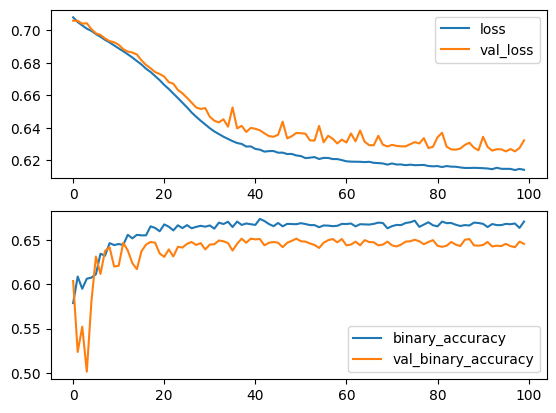

In [ ]:
from keras.regularizers import l2

lmbda = 0.01

rest_days_model = Sequential()
rest_days_model.add(keras.Input(shape=(3,)))
rest_days_model.add(Dense(20, activation = 'relu'))
rest_days_model.add(Dense(10, activation = 'relu'))
rest_days_model.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

rest_days_model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Accuracy()])

# fit the model to the training data
history = rest_days_model.fit(rd_train_input, rd_train_label, epochs=100, validation_data = (rd_test_input, rd_test_label))

result = rest_days_model.evaluate(x=rd_test_input, y=rd_test_label)
dict(zip(rest_days_model.metrics_names, result))

plot_model_results(history.history)

# Combining Stats with Batch Normalization

In [ ]:
bn_2021 = add_days_rest_column(season_2021, more_2021)
bn_2022 = add_days_rest_column(season_2022, more_2022)
bn_2023 = add_days_rest_column(season_2023, more_2023)

bn_merged = pd.concat([bn_2021, bn_2022, bn_2023])
bn_merged = bn_merged.sample(frac=1) # Shuffle the data
bn_merged

,TEAM_NAME,TEAM_ABBREVIATION,TEAM_ID,GAME_ID,OPPONENT_ABBREVIATION,OPPONENT_ID,WL,TEAM_W_PCT,OPPONENT_W_PCT,TEAM_FGA,...,TEAM_STL,OPPONENT_STL,TEAM_PFD,OPPONENT_PFD,TEAM_PLUS_MINUS,OPPONENT_PLUS_MINUS,WIN,GAME_DATE,LAST_GAME_DATE,NUM_REST_DAYS
269,Portland Trail Blazers,POR,1610612757,0022301068,MIA,1610612748,L,0.256,0.561,7356,...,627,617,1467,1550,-740.0,144.0,0,2024-03-29,2024-03-27,2
927,Phoenix Suns,PHX,1610612756,0022300739,UTA,1610612762,W,0.598,0.378,7063,...,610,537,1612,1577,251.0,-401.0,1,2024-02-08,2024-02-06,2
2123,Utah Jazz,UTA,1610612762,0022200162,ATL,1610612737,W,0.451,0.500,7365,...,500,580,1679,1612,-77.0,24.0,1,2022-11-09,2022-11-07,2
1293,New York Knicks,NYK,1610612752,0022200582,TOR,1610612761,W,0.573,0.500,7328,...,527,772,1694,1604,240.0,121.0,1,2023-01-06,2023-01-04,2
2222,Miami Heat,MIA,1610612748,0022100121,BOS,1610612738,L,0.646,0.622,6954,...,606,591,1686,1592,365.0,597.0,0,2021-11-04,2021-11-02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,Milwaukee Bucks,MIL,1610612749,0022200723,DEN,1610612743,W,0.707,0.646,7411,...,521,618,1557,1601,298.0,273.0,1,2023-01-25,2023-01-23,2
2249,Los Angeles Lakers,LAL,1610612747,0022100107,HOU,1610612745,W,0.402,0.244,7279,...,626,600,1647,1812,-250.0,-695.0,1,2021-11-02,2021-10-31,2
208,Indiana Pacers,IND,1610612754,0022201123,DAL,1610612742,L,0.427,0.463,7345,...,631,514,1660,1789,-261.0,6.0,0,2023-03-27,2023-03-25,2
1586,Atlanta Hawks,ATL,1610612737,0022300408,CHI,1610612741,L,0.439,0.476,7584,...,615,638,1594,1538,-179.0,-118.0,0,2023-12-26,2023-12-23,3


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - binary_accuracy: 0.5093 - loss: 0.7595 - val_binary_accuracy: 0.5084 - val_loss: 0.7595
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.5631 - loss: 0.6987 - val_binary_accuracy: 0.5744 - val_loss: 0.6884
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.5914 - loss: 0.6800 - val_binary_accuracy: 0.6038 - val_loss: 0.6700
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.5943 - loss: 0.6728 - val_binary_accuracy: 0.6155 - val_loss: 0.6615
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6110 - loss: 0.6604 - val_binary_accuracy: 0.6189 - val_loss: 0.6568
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6192 - loss: 0.6553 - val_binary_accuracy: 0.6197 - val_loss: 0.6537
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6282 - loss: 0.6446 - val_binary_accuracy: 0.6206 - val_loss: 0.6510
Epoch 

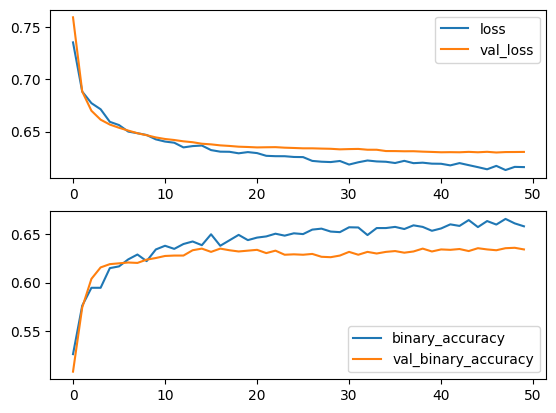

In [ ]:
bn_stats = generate_nn_labels(addl_stats)
bn_stats.append("NUM_REST_DAYS")
bn_raw_input_cols = bn_merged[bn_stats].to_numpy()

raw_bn_outputs = bn_merged["WIN"].to_numpy()

training_size = 5000

train_input = bn_raw_input_cols[:training_size]
train_label = raw_bn_outputs[:training_size]

test_input = bn_raw_input_cols[training_size:]
test_label = raw_bn_outputs[training_size:]

from keras.regularizers import l2
from keras.layers import BatchNormalization

lmbda = 0.01

bn_model = Sequential()
bn_model.add(keras.Input(shape=(27,)))
bn_model.add(BatchNormalization())
bn_model.add(Dense(20, activation = 'relu'))
bn_model.add(BatchNormalization())
bn_model.add(Dense(10, activation = 'relu'))
bn_model.add(BatchNormalization())
bn_model.add(Dense(10, activation = 'relu'))
bn_model.add(BatchNormalization())
bn_model.add(Dense(10, activation = 'relu'))
bn_model.add(Dense(1, kernel_regularizer=l2(lmbda), activation='sigmoid'))

bn_model.compile(optimizer='sgd',
              loss=BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])

# fit the model to the training data
history = bn_model.fit(train_input, train_label, epochs=50, validation_data = (test_input, test_label))

result = bn_model.evaluate(x=test_input, y=test_label)
dict(zip(bn_model.metrics_names, result))

plot_model_results(history.history)